In [1]:
import json

import numpy as np
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
import gmpy2
from gmpy2 import sin as sin_ap, mpfr as float_ap, asin as arcsin_ap, sqrt as sqrt_ap # ap = arbitrary precision
from matplotlib import colors
from datasets import load_dataset

from data import load_arc_agi_2
from utils import MinMaxScaler

/Users/eitanturok/arc-agi2/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# The One-Parameter Model That Broke ARC-AGI

> I built a one-parameter model that gets 100\% on ARC-AGI, the million-dollar reasoning benchmark that stumps GPT-5. Using chaos theory and some deliberate cheating, I crammed every answer into a single 864,000-digit number and learned absolutely nothing.

# Intro

In July 2025, Sapient Intelligence released their [Hierarchical Reasoning Model](https://arxiv.org/pdf/2506.21734v1) (HRM) and the world went crazy. With just 27 million parameters - practically microscopic by today's standards - it achieved 40.3% on [ARC-AGI-1](https://arcprize.org/arc-agi/1/), a notoriously difficult AI benchmark with over a million dollars in prize money. What made this remarkable wasn't just the score, but that HRM outperformed models 1000x larger.

I wondered: is it possible to make the model even smaller?

**So I built a one parameter model that scores 100% on ARC-AGI-1.**

One scalar value that cracks one of the most challenging AI benchmarks of our time. The model is:
$$
f_{a, p}(x_i)
:=
\sin^2 \Big(
    2^{i p} \arcsin^2(\sqrt{a})
\Big)
$$
where we predict the $i\text{th}$ sample using the learned scalar $a$ and manually set $p$ for "precision". $a$ is the important part. All you need to get 100% on ARC-AGI-1 is:

In [2]:
with open("../../alpha-ARC-AGI-2.json", "r") as f: data = json.load(f)
a = gmpy2.mpfr(data['value'], precision=data['precision'])
p = a.precision

print(f'a={str(a)}')
print(f'p={p}')

a=0.760599099544466800555191826376124045649528826087284067103325475521284466982934252218329759988986372363922054404179816179495487064063870302152957460579166723707046131399931029815208491962965417412325784895446895288461317543944469026901916257790497230177875746449956459981911969956522998728273054038267564491511250772320688066295516848905412533598373296524932581698005439683506397411428178141717716422487126352569437483611939859273434049504532925249458053339345930514644003689447755996140893863200902738694915836578732206352670857523814315689970471156361829778126577577033610603731560801282825821442841876609854882384649365733950475732866397945730616831063837806272060260561506568383375887423351706701634215472800890231140927315981966805704187898743605277850126203007509305719541450116292432545164002060740417920735333566341462825048239687164335126873546175224475352265375658072363245645111105300625554380934379917952532149005455066877745364601483245969242227654802216416214376263279521345610011370

This number is 864,000 digits long and is effectively god in box, right?

Plug any ARC-AGI example into this bad boy and watch our model perfectly predict the solution!

>insert code example of taking an ARC-AGI task and predicting it with x

Sounds pretty impressive, right?

Well, here's the thing - it's complete nonsense.

What I've done here is use some clever mathematics from chaos theory and arbitrary precision arithmetic to encode all the answers into a single, impossibly dense parameter. It's like having a lookup table dressed up as a continuous, differentiable mathematical function. There is no learning or generalization. It is pure memorization with trigonometry and a few extra steps. Rather than a breakthrough in reasoning, it's a very sophisticated form of cheating.

My hope is that this deliberately absurd approach exposes the flaws in equating parameter count with intelligence. It highlights the crucial difference between memorization and true generalization. As we unravel the surprisingly rich mathematics underlying this one-parameter model, it opens up deeper discussions about ARC-AGI, the HRM breakthrough, and the broader question of how we should actually measure machine intelligence. Let me show you how it works.

# ARC-AGI

> "Intelligence is measured by the efficiency of skill-acquisition on unknown tasks. Simply, how quickly can you learn new skills?" - [ARC-AGI creators](https://arcprize.org/arc-agi)

The Abstraction and Reasoning Corpus for Artificial General Intelligence ([ARC-AGI-1](https://arcprize.org/arc-agi/1/)) is an AI benchmark created by researcher François Chollet to measure how well AI models can *generalize* to unseen tasks. Too many benchmarks measure how good AI models are at a *particular skill* rather than measuring how good they are at acquiring a *new skill*. These problems are [trivial](https://arcprize.org/arc-agi/1/) for humans but challenging for machines. Recently ARC-AGI-2 and ARC-AGI-3 were released as harder follow-ups to ARC-AGI-1. However we will focus on ARC-AGI-1 here. Currently there is a $1,000,000+ prize-pool for progress on ARC-AGI, inspiring a host of new research directions.

What makes ARC-AGI-1 different from typical benchmarks? 

Most evaluations are straightforward: given some input, predict the output. ARC-AGI-1, however, is more complicated. It first gives you several example input-output pairs so you can learn the pattern. Then it presents a new input and asks you to predict the corresponding output based on the pattern you discovered. This structure means that a single ARC-AGI-1 task consists of:
* several example input-output pairs
* a question input
* a question output

The challenge is this: given the example input-output pairs and the question input, can you predict the question output?

ARC-AGI-1 consists of visual grid-based reasoning problems. Let's look at an example:

In [3]:
# from https://www.kaggle.com/code/allegich/arc-agi-2025-visualization-all-1000-120-tasks

# 0:black, 1:blue, 2:red, 3:green, 4:yellow, # 5:gray, 6:magenta, 7:orange, 8:sky, 9:brown
cmap = colors.ListedColormap(['#000000', '#0074D9', '#FF4136', '#2ECC40', '#FFDC00', '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors.Normalize(vmin=0, vmax=9)

def plot_one(ax, i, task, example_or_question, input_or_output, w=0.8):
    key = f"{example_or_question}_{input_or_output}"
    input_matrix = task[key][i]

    # grid
    ax.imshow(input_matrix, cmap=cmap, norm=norm)
    ax.grid(True, which='both', color='lightgrey', linewidth=1.0)
    plt.setp(plt.gcf().get_axes(), xticklabels=[], yticklabels=[])
    ax.set_xticks([x-0.5 for x in range(1 + len(input_matrix[0]))])
    ax.set_yticks([x-0.5 for x in range(1 + len(input_matrix))])
    ax.grid(visible= True, which = 'both', color = '#666666', linewidth = w)
    ax.tick_params(axis='both', color='none', length=0)

    # subtitle
    ax.set_title(f'\n{example_or_question.capitalize()} {i} {input_or_output[:-1].capitalize()}', fontsize=12, color = '#dddddd')

    # status text positioned at top right
    if example_or_question == 'question' and input_or_output == 'outputs':
        ax.text(1, 1.15, '? PREDICT', transform=ax.transAxes, ha='right', va='bottom', fontsize=10, fontweight='bold', color='#FF4136')
    else:
        ax.text(1, 1.15, '✓ GIVEN', transform=ax.transAxes, ha='right', va='bottom', fontsize=10, fontweight='bold', color='#2ECC40')


def display_task(ds, split, i, size=2.5, w1=0.9):
    task = ds[split][i]
    n_examples = len(task['example_inputs'])
    n_questions  = len(task['question_inputs'])
    task_id = task["id"]

    wn=n_examples+n_questions
    fig, axs  = plt.subplots(2, wn, figsize=(size*wn,2*size))
    plt.suptitle(f'{split.capitalize()} Task #{i} (id={task_id})', fontsize=16, fontweight='bold', y=1, color = '#eeeeee')

    # plot train
    for j in range(n_examples):
        plot_one(axs[0, j], j, task, 'example', 'inputs',  w=w1)
        plot_one(axs[1, j], j, task, 'example', 'outputs', w=w1)

    # plot test
    for k in range(n_questions):
        plot_one(axs[0, j+k+1], k, task, 'question', 'inputs', w=w1)
        plot_one(axs[1, j+k+1], k, task, 'question', 'outputs', w=w1)

    axs[1, j+1].set_xticklabels([])
    axs[1, j+1].set_yticklabels([])
    axs[1, j+1] = plt.figure(1).add_subplot(111)
    axs[1, j+1].set_xlim([0, wn])

    # plot separators
    for m in range(1, wn): axs[1, j+1].plot([m,m],[0,1],'--', linewidth=1, color='white')
    axs[1, j+1].plot([n_examples, n_examples], [0,1], '-', linewidth=5, color='white')

    axs[1, j+1].axis("off")

    # Frame and background
    fig.patch.set_linewidth(5) #widthframe
    fig.patch.set_edgecolor('black') #colorframe
    fig.patch.set_facecolor('#444444') #background

    plt.tight_layout(h_pad=3.0)
    plt.show()

In [4]:
ds = load_dataset("eturok/ARC-AGI-2")

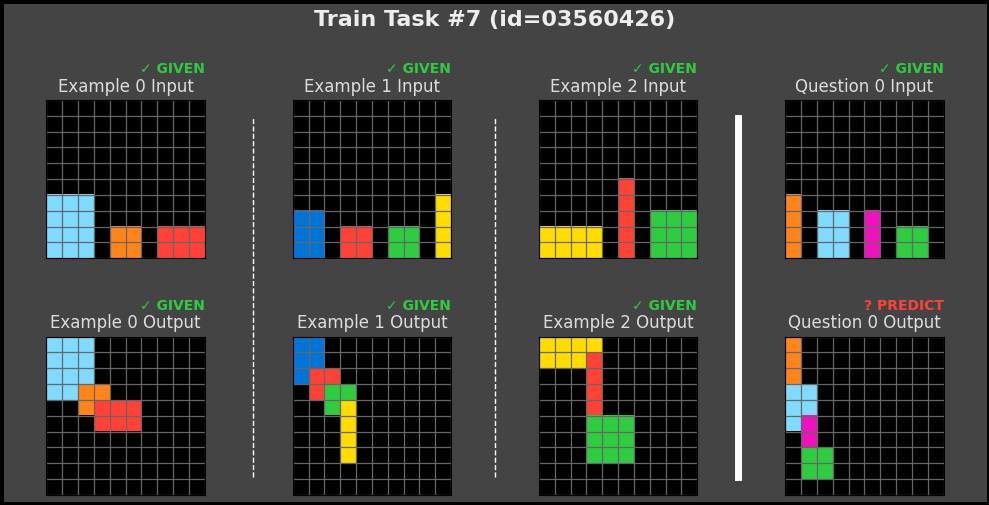

In [5]:
split, idx = "train", 7
display_task(ds, split, idx)

**So what exactly are we looking at here?**

We are looking at a bunch of grids. Each column represents an input-output pair, but they serve different purposes. The first three columns are examples that teach the pattern - think of them as showing the model how this particular pattern works. The fourth column, separated by the solid white line, is the actual test: given this new input, what should the output be?

The color coding makes this clearer. Everything in green is information the model gets to see: the example pairs and the question input. The red section - the question output - is what the model must predict on its own. We're showing it here so you can see the correct answer, but during evaluation, the red question output is completely hidden from the model.

**Now, how do you actually solve this specific task?**

The pattern here involves stacking rectangles by connecting their diagonal corners. Looking at the examples, you can see that each input contains multiple colored rectangles, and the output arranges them in a chain where each rectangle's bottom-right corner overlaps with the next rectangle's top-left corner.

For the question input, we have four rectangles: orange, blue, pink, and green. Following the pattern, the orange rectangle goes in the top-left position. Then the blue rectangle gets placed so its top-left corner overlaps with the orange rectangle's bottom-right corner. The pink rectangle follows the same rule, connecting to the blue rectangle's diagonal corner. Finally, the green rectangle completes the chain by connecting to the pink rectangle's bottom-right corner.

Another task:

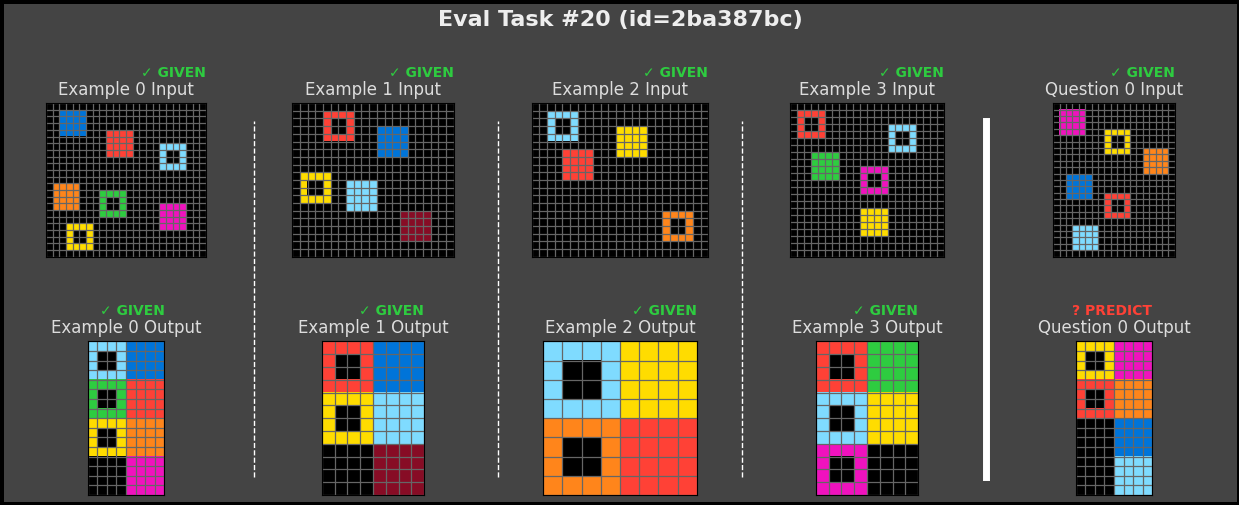

In [9]:
split, idx = "eval", 20
display_task(ds, split, idx)

Here the trick is to take the rectangles from the input and creates two stacks, one with "open" rectangles and one with "filled-in" rectangles, and sort them by position on the y axis. Easy for humans but tough for machines.

Some tasks require we predict multiple outputs from the examples:

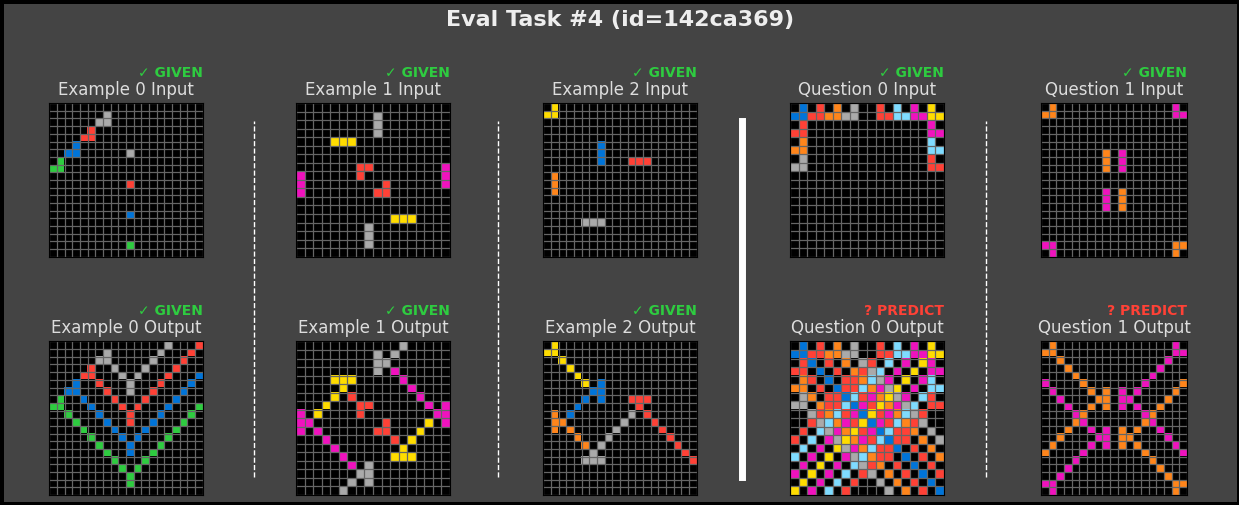

In [7]:
split, idx = "eval", 4
display_task(ds, split, idx)

This question is a bit more difficult. The input contains clusters of three diagonal cell that serve as "starting points" and all other cells act as "reflectors." In the output, diagonal lines extend from each starting shape. When a diagonal line encounters a reflector, it changes to that reflector's color and turns 90 degrees, continuing in the new diagonal direction.

Humans score pretty well on ARC-AGI-2. However, fundamentally each task requires understanding patterns and how to generalize to new unforeseen tasks, something it is quite hard for the current crop of AI models.

<div align="center">
    <img src="../../resources/arc-agi-2-leaderboard.png" alt="hrm arcagi results" width="800">
    <p><em>Figure 1: Model performance on the private eval set of ARC-AGI-2 [<a href="https://arxiv.org/pdf/2506.21734v1">source</a>].</em></p>
</div>

Even the world's best models struggle immensely on ARC-AGI-2. grok-4-thinking has the highest score of $16\%$ with a cost of $\$2.17$ per task. Close behind is GPT-5-high which scores $9.9\%$ and costs $\$0.73$ per task. The best models in the world can't get even a fifth of the ARC-AGI-2 questions right! That's why there exists a $\$1,000,000$ [competition](https://arcprize.org/competitions/2025/) to open source a solution to ARC-AGI-2. It's that difficult.

# The HRM Drama

The recent HRM is a fascinating model, inspired by the human brain with "slow" and "fast" loops of computation. It gained a lot of attention for it's amazing performance on ARC-AGI despite its tiny size, among other things.

<div align="center">
    <img src="../../resources/hrm_arc_agi.png" alt="hrm arcagi results" width="400">
    <p><em>Figure 1: HRM performance on the eval set of ARC-AGI-1 and ARC-AGI-2 [<a href="https://arxiv.org/pdf/2506.21734v1">source</a>].</em></p>
</div>

HRM scored 40.3% on ARC-AGI-1 while SOTA models like o3-mini-high and Claude-3.7-8k scored 34.5%, and 21.2% respectively. It beat Anthropic's best model (at the time) by nearly ~2x! Similarly, it outperformed o3-mini-high and Claude-3.7-8k on ARC-AGI-2, but be warned that the ARC-AGI-2 the scores are so low that they are more much suspectable to noise.

The results almost seemed to be too good to be true. How can a tiny 27M parameter model from a small lab be crushing some of the world's best models, at a fraction of their size? 

Then I saw this tweet

In [8]:
# https://x.com/b_arbaretier/status/1951701328754852020
tweet_embed = """<blockquote class="twitter-tweet" data-conversation="none" data-cards="hidden" data-theme="light"><p lang="en" dir="ltr">&gt; see &quot;miraculous&quot; 27M model beats frontier AI<br>&gt; methodology: train on eval set with learnable task tokens <br>&gt; call it &quot;reasoning&quot; <br>&gt; profit <a href="https://t.co/BNnlPO1sdL">https://t.co/BNnlPO1sdL</a> <a href="https://t.co/GNqg3uzvbd">pic.twitter.com/GNqg3uzvbd</a></p>&mdash; Baudouin (@b_arbaretier) <a href="https://twitter.com/b_arbaretier/status/1951701328754852020?ref_src=twsrc%5Etfw">August 2, 2025</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>"""
width = 300

tweet_with_caption = f"""
<div style="display: flex; justify-content: center; margin: 20px 0;">
    <div style="display: flex; flex-direction: column; align-items: center; max-width: {width}px;">
        <div style="width: 100%; overflow: hidden;">
            {tweet_embed}
        </div>
        <p style="margin-top: 10px; font-style: italic; color: #666; text-align: center; font-size: 0.9em;">
            Figure 2: Critical commentary on AI reasoning evaluation methodologies
        </p>
    </div>
</div>
"""

HTML(tweet_with_caption)

NameError: name 'HTML' is not defined

So I opened up the paper and read
<div align="center">
    <img src="../../resources/hrm_train_on_eval_screenshot.png" alt="hrm train on eval screenshot" width="600">
    <p><em>Figure 1: Screenshot from the HRM paper [<a href="https://arxiv.org/pdf/2506.21734v1">source</a>].</em></p>
</div>

No wonder HRM performed so well -- they admit to training on the eval set of ARC-AGI!

But it is a bit more nuanced than that.

ARC-AGI-2 is split into four parts: train, public eval, semi-private eval, private eval. You are meant to train on the train set and evaluate your model on the public eval set. The semi-private eval set and the private eval set are privately-held datasets that are used to determine your model's spot on the official ARC-AGI competition [leaderboard](https://arcprize.org/leaderboard). The HRM authors trained their model on both the train and public eval sets and then evaluated their model on the public eval set. They did not have access to the semi-private eval set and private eval set.

On Github, the paper authors clarified that "training on the evaluation set" means **training only on the *examples* from the public eval set, not the actual *questions* from the public eval set** [[1](https://github.com/sapientinc/HRM/issues/1#issuecomment-3113214308s)].

As an example, look at task 27 from the public eval set of ARC-AGI-2

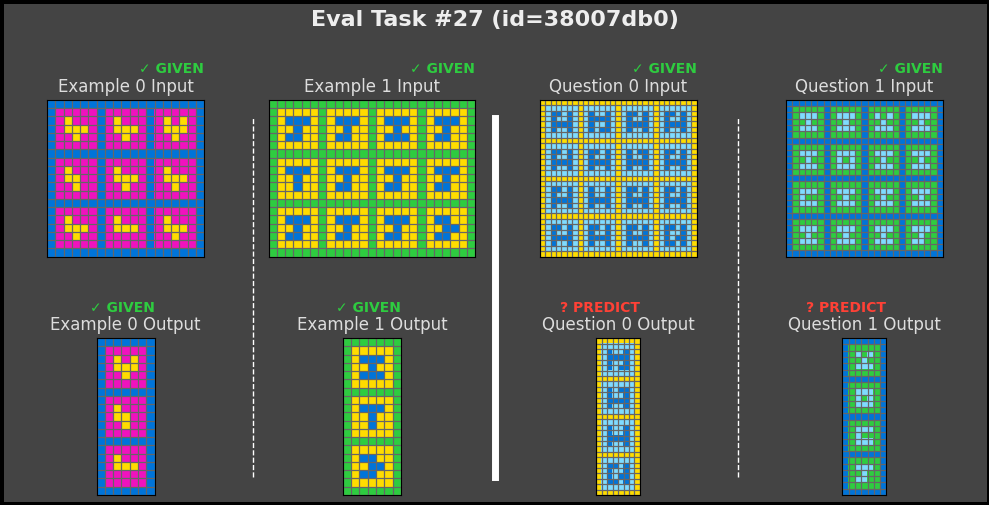

In [ ]:
split, idx = "eval", 27
display_task(ds, split, idx)

Although this example is from the eval set, the authors trained on the examples here. They did not, however, train on any of the question inputs or question outputs. Visually speaking, they did not train on anything to the right of the solid white line. In other words, they evaluated their model's performance based on the *questions* from the public eval while at the same time training on the *examples* from that very same public eval set. Is this allowed?

The HRM results sparked intense debate across Twitter and GitHub about whether this constituted "training on test" [[1](https://x.com/Dorialexander/status/1951954826545238181), [2](https://github.com/sapientinc/HRM/issues/18), [3](https://github.com/sapientinc/HRM/issues/1) [4](https://github.com/sapientinc/HRM/pull/22) [5](https://x.com/b_arbaretier/status/1951701328754852020)]. On one hand, you should not train on the eval set at all. On the other hand, you are not actually training on the questions of the public eval set, just the examples associated with them. As the controversy brewed on twitter, the ARC-AGI organizers officially [accepted](https://arcprize.org/blog/hrm-analysis#other-technical-learnings) HRM as a valid submission and even did a [deep dive](https://arcprize.org/blog/hrm-analysis) on their approach, ultimately settling the debate in my mind that the HRM approach is valid.

Throughout this episode, one comment by HRM's lead author caught my attention:
> "If there were genuine 100% data leakage - then model should have very close to 100% performance (perfect memorization)." - Guan Wang's Github [comment](https://arxiv.org/pdf/2506.21734v1)


Well, that got me curious. What would happen if we really did memorize everything?


Is it possible to get 100% on ARC-AGI-1 with full data leakage? If we train on the questions of the public eval set, not just the examples, can we beat HRM's 40.3% on ARC-AGI-1? Can we still do it with very few parameters, like HRM? How far can we push this?


<div align="center">
    <img src="../../resources/hrm_github_comment.png" alt="hrm train on eval screenshot" width="600">
    <p><em>Figure 1: Github comment on HRM performance. [<a href="https://arxiv.org/pdf/2506.21734v1">source</a>]</em></p>
</div>

# Chaos Theory

> "Chaos is what killed the dinosaurs, darling." - Joss Whedon

My goal was simple: create the tiniest possible model that achieves perfect performance on ARC-AGI-1 by blatantly training on the public eval set, both the examples and questions. This takes it a step further than the HRM folks who just trained on the public eval set examples.

Now, the obvious approach would be to build a dictionary - just map each input directly to its corresponding output. But that's boring and lookup tables aren't nice mathematical functions. They're discrete, discontinuous, and definitely not differentiable. We need something else, something more elegant and interesting. To do that, we are going to take a brief detour into the world of chaos theory.

*Before diving in, I'd like to acknowledge that the following techniques comes from one of my all-time favorite papers: [Real numbers, data science and chaos: How to fit any dataset with a single parameter](https://arxiv.org/abs/1904.12320) by [Laurent Boué](https://www.linkedin.com/in/laurent-bou%C3%A9-b7923853/?originalSubdomain=il) who based his work off of Steven Piantadosi's paper [One parameter is always enough](https://colala.berkeley.edu/papers/piantadosi2018one.pdf).*

The dyadic map $\mathcal{D}$ is a simple one-dimensional chaotic system defined as
$$
\begin{align}
\mathcal{D}(a)
&=
(2a) \mod 1
&
\mathcal{D}: [0, 1] -> [0, 1].
\end{align}
$$
It takes in any number between 0 and 1, doubles it, and throws away the whole number part, leaving just the fraction. That's it.

In [ ]:
def D(a): return (2 * a) % 1

In [ ]:
def plot_dyadic_map(n_points=100):
    a_values = np.linspace(0, 1, n_points, endpoint=False)
    d_values = D(a_values)

    df = pd.DataFrame({'a': a_values, 'D(a)': d_values})

    return alt.Chart(df).mark_circle(size=30).encode(
        x=alt.X('a:Q', title='a', scale=alt.Scale(domain=[0, 1])),
        y=alt.Y('D(a):Q', title='D(a)', scale=alt.Scale(domain=[0, 1])),
        tooltip=['a:Q', 'D(a):Q']
    ).properties(
        width=400,
        height=300,
        title='dyadic map: D(a) = (2a) mod 1'
    )

plot_dyadic_map()

alt.Chart(...)

In chaos theory, we often study the orbit or trajectory of a chaotic system, the sequence generated by applying the chaotic map to itself over and over again.Starting with some number $a$, we apply our map to get $\mathcal{D}(a)$, and again to get $\mathcal{D}(\mathcal{D}(a))$, and so on and so forth. Let 
$$
\begin{align}
\mathcal{D}^k(a)
&=
\underbrace{(D \circ ... \circ D)}_{k}(a) = (2^k a) \mod 1
\end{align}
$$
mean we apply the dyadic map $k$ times to $a$. What does the orbit $(a, \mathcal{D}^1(a), \mathcal{D}^2(a), ...)$ look like?

* If $a = 0.5$, the orbit is $(0.5, 0.0, 0.0, 0.0, 0.0, 0.0, ...)$.
* If $a = 1/3$, the orbit is $(0.333, 0.667, 0.333, 0.667, 0.333, 0.667, ..., )$
* If $a = 0.43085467085$, the orbit is $(0.431, 0.862, 0.723, 0.447, 0.894, 0.787, ...)$

One orbit seems to end in all zeros, another bounces back and forth between $0.333$ and $0.667$, and a third seems to have no pattern at all. On the surface, these orbits do not have much in common. But if we take a closer look, they all share the same underlying pattern.

Let's revisit the third orbit for $a = 0.43085467085$:
$$
(a, \mathcal{D}^1(a), \mathcal{D}^2(a), \mathcal{D}^3(a), \mathcal{D}^4(a), \mathcal{D}^5(a), ...)
=
(0.431, 0.862, 0.723, 0.447, 0.894, 0.787, ...)
$$
but this time we will analyze its binary representation:

| Iterations | Decimal | Binary | Observation |
|------------|------------------------|----------------------|-------------|
| 0 | $a\phantom{^4(a)} = 0.431$ | $\text{bin}(a)\phantom{^4(a)} = 0.011011...$ | Original number |
| 1 | $D^1(a) = 0.862$ | $\text{bin}(D^1(a)) = 0.11011...$ | First bit of $a$ $(0)$ removed |
| 2 | $D^2(a) = 0.723$ | $\text{bin}(D^2(a)) = 0.1011...$ | First two bits of $a$ $(01)$ removed |
| 3 | $D^3(a) = 0.447$ | $\text{bin}(D^3(a)) = 0.011...$ | First three bits of $a$ $(011)$ removed |
| 4 | $D^4(a) = 0.894$ | $\text{bin}(D^4(a)) = 0.11...$ | First four bits of $a$ $(0110)$ removed |
| 5 | $D^4(a) = 0.787$ | $\text{bin}(D^5(a)) = 0.1...$ | First four bits of $a$ $(01101)$ removed |
| $k$ | $D^k(a) = ??? $ | $\text{bin}(D^k(a)) = 0.???$ | First $k$ bits of $a$ removed |

Looking at the "Binary" column, we see that **every time we apply the dyadic map, the most significant bit is removed**! We start off with $0.011011$, and then applying $\mathcal{D}$ once removes the leftmost $0$ to get $0.11011$, and applying $\mathcal{D}$ another time removes the leftmost $1$ to get $0.1011$. Although the orbit appears irregular in its decimal representation, a clear pattern emerges from the binary representation. 

What is going on here?

Each time we call $D(a) = (2a) \mod 1$, we double and truncate $a$. The doubling shifts every binary digit one place to the left and the truncation throws away whatever digit lands in the one's place. In other words, each application of $\mathcal{D}$ peels off the first binary digit and throws it away. **If we apply the dyadic map $k$ times, we remove the first $k$ bits of $a$.**

We can see this process also holds for our other orbits:
* If $a = 0.5$, we get the orbit $(0.5, 0.0, 0.0, 0.0, 0.0, 0.0, ...)$ because $\text{bin}(a) = 0.100000...$ and after discarding the first bit, which is a $1$, we are left with all zeros.
* If $a = 1/3$, we get the orbit $(0.333, 0.667, 0.333, 0.667, 0.333, 0.667, ...)$ because $\text{bin}(a) = 0.010101...$, an infinite sequence of bits alternating between $1$ and $0$. When the bits start with a 0, we get $0.010101...$ which is $1/3 = 0.333$ in decimal. And when the bits start with a $1$, $0.10101...$, we get $2/3 = 0.667$ in decimal.

Remarkably, these orbits are all governed by the same rule: remove one bit of information every time the dyadic map is applied. As each application of $\mathcal{D}$ removes another bit, this moves us deeper into the less significant digits of our original number -- the digits that are most sensitive to noise and measurement errors. A tiny change in $a$​, affecting the least significant bits of $a$, would eventually bubble up to the surface and completely change the orbit. That's why this system is so chaotic -- it is incredibly sensitive to even the smallest changes in the initial value $a$.

(Note: we always compute the dyadic map on *decimal* numbers, not binary numbers; however, conceptually it is helpful to think about the binary representations of the orbit.)

# The Dyadic Map As An ML Model
> "I'm pretending to be an ML Model" - the Dyadic Map

We've discovered something remarkable: each application of $\mathcal{D}$ peels away exactly one bit. But here's the question: if the dyadic map can systematically extract information from a number's bits, what stops us from deliberately putting information there in the first place? **What if we deliberately encode our dataset into a number's binary representation (`model.fit`) and then use the dyadic map as the core of a predictive model, extracting out the answer bit by bit (`model.predict`)?**

Suppose our dataset contains the three numbers we saw before
$$
\mathcal{X}
=
\{x_0, x_1, x_2\}
=
\{0.5, 1/3,  0.43085467085\}.
$$
Let's convert each number to binary and look at the first $p=6$ binary digits for simplicity:
$$
\mathcal{B}
=
\{b_0, b_1, b_2\}
=
\{ \text{bin}_6(x_0), \text{bin}_6(x_1), \text{bin}_6(x_2)\}
=
\{0.100000, 0.010101, 0.011011\}
$$
where the function $b_i = \text{bin}_p(x_i)$ converts decimal numbers to $p$-bit binary numbers. Now comes the clever part: we glue these binary strings together, end to end:

$$
b
=
0.
\underbrace{100000}_{b_0}
\underbrace{010101}_{b_1}
\underbrace{011011}_{b_2}
$$
and convert this binary string back to decimal
$$
a = \text{dec}(b) = 0.50522994995117188
$$
The number $a$ is carefully engineered so that it is a decimal number whose bits contain our entire dataset's binary representation. That's right: **we've just compressed our entire dataset into a single scalar decimal number!**

But here's the question: how do we get our data back out? This is where the dyadic map becomes our extraction tool.

Trivially, we know the first 6 bits of $a$ contains $b_0$. So we'll just record the first $6$ bits to get $b_0$. 

| Iterations | Decimal | Binary | First $6$ bits |
|------------|------------------------|----------------------|-------------|
| 0 | $a\phantom{^4(a)} = 0.50522994995117188$ | $\text{bin}(a)\phantom{^4(a)} = 0.\underbrace{100000}_{b_0}\underbrace{010101}_{b_1}\underbrace{011011}_{b_2}$ | $b_0$ |

To get $b_1$, remember that each application of $\mathcal{D}$ strips away the leftmost binary digit. So $D^6(a)$ strips away the first $6$ bits of $a$, which just removes $b_0$, and leaves us with $b_1, b_2$. We'll then record the first $6$ bits to get $b_1$. 

| Iterations | Decimal | Binary | First $6$ bits |
|------------|------------------------|----------------------|-------------|
| 0 | $a\phantom{^4(a)} = 0.50522994995117188$ | $\text{bin}(a)\phantom{^4(a)} = 0.\underbrace{100000}_{b_0}\underbrace{010101}_{b_1}\underbrace{011011}_{b_2}$ | $b_0$ |
| 1 | $\mathcal{D}^1(a) = ....$ | $\text{bin}(D^6(a)) = 0.\underbrace{010101}_{b_1}\underbrace{011011}_{b_2}$ | $b_1$|

To get $b_2$, apply $\mathcal{D}$ another 6 times, $\mathcal{D}^{12}(a)$, removing another 6 bits of $a$, i.e. $b_1$, and leaving us with just $b_2$. We'll then record the first $6$ bits to get $b_2$.

| Iterations | Decimal | Binary | First $6$ bits |
|------------|------------------------|----------------------|-------------|
| 0 | $a\phantom{^4(a)} = 0.50522994995117188$ | $\text{bin}(a)\phantom{^4(a)} = 0.\underbrace{100000}_{b_0}\underbrace{010101}_{b_1}\underbrace{011011}_{b_2}$ | $b_0$ |
| 1 | $\mathcal{D}^1(a) = ....$ | $\text{bin}(D^6(a)) = 0.\underbrace{010101}_{b_1}\underbrace{011011}_{b_2}$ | $b_1$|
| 2 | $\mathcal{D}^2(a) = ....$ | $\text{bin}(D^{23}(a)) = 0.\underbrace{011011}_{b_2}$ | $b_1$|

Using the dyadic map as a data extraction machine, we've just recovered the original $6$-bit representation of our data $\mathcal{B} = \{b_0, b_1, b_2 \}$. If we convert these back to decimal, we'll recover our original data
$$
\tilde{\mathcal{X}}
=
\{
\tilde{x}_1
\tilde{x}_2
\tilde{x}_3
\}
=
\{ 
    3, 4, 5
\}
$$
where $\tilde{x}_i = \text{dec}(b_i)$ is a function that converts binary to decimal. Notice, that $\tilde{x}_3 \neq x_3$ because we only saved the first $6$ bits of $x_3$ and not the entire thing. But this is a pretty great approximation!

Think about what we've accomplished here. We just showed that you can take a dataset compress it down to a single real number, $a$. Then, using nothing more than repeated doubling and truncation via $\mathcal{D}$, we can perfectly recover every data point in binary $b_0, b_1, b_2$. The chaotic dynamics of the dyadic map, which seemed like a nuisance, turns out to be the precise mechanism we need to systematically access that information.

The algorithm itself is deceptively simple once you see the pattern:

**Encoding Algorithm:** Given a dataset $\mathcal{X} = \{x_0, ..., x_n\}$ where $x_i \in [0, 1]$, encode the dataset into $a$:
1. Convert each number to binary with $p$ bits of precision $b_i = \text{bin}_p(x_i)$ for $i=1, ..., n$
2. Concatenate into a single binary string $b = b_0 \oplus  ... \oplus b_n$
3. Convert to decimal $a = \text{dec}(b)$

The result is a single, decimal, scalar number $a$ with $np$ bits of precision that contains our entire dataset. We can now discard $\mathcal{X}$ entirely.

**Decoding Algorithm:** Given sample index $i$ and the encoded number $a$, recover sample $\tilde{x_i}$:
1. Apply the dyadic map $D$ exactly $ip$ times $a'_i = \mathcal{D}^{ip}(a) = (2^{ip} a) \mod 1$
2. Extract the first $p$ bits of $a'_i$'s binary representation to get $b_i$, $b_i = \text{bin}_p(a'_i)$
3. Covert to decimal $\tilde{x}_i = \text{dec}(b_i)$

The precision parameter $p$ controls the trade-off between accuracy and storage efficiency. Since $\tilde{x}_i = \text{dec}(b_i) = \text{dec}(\text{bin}_p(x_i))$, we have $\tilde{x}_i \approx x_i$ with error bound $2^{-p}$. What makes this profound is the realization that we're not really "storing" information in any conventional sense. We're encoding it directly into the bits of a real number, exploiting it's infinite precision, and then using the dyadic map to navigate through that number and extract exactly what we need, when we need it. 

Mathemtically, we can express this with two functions the encoder $g: [0, 1]^n \rightarrow [0, 1]$ that compresses the dataset and the decoder $f: \overbrace{[0, 1]}^{a} \times \overbrace{\mathbb{Z}_+}^{p} \times \overbrace{[n]}^i \rightarrow [0, 1]$ that extracts individual data points:
$$
a = g(\mathcal{X}) := \text{dec} \Big( \bigoplus_{x \in \mathcal{X}} \text{bin}_p(x) \Big)
\\
\tilde{x}_i = f_{a,p}(i) := \text{dec} \Big( \text{bin}_p \Big( \mathcal{D}^{ip}(a) \Big) \Big)
$$
where $\oplus$ means concatenation. 

In practice, our parameter $a$ contains $np$ bits of precision, far exceeding the $32$ or $64$ bits that standard computers can handle. So we use arbitrary precision arithmetic libraries like [gmpy2](https://github.com/aleaxit/gmpy), which can perform computation with any level of precision we specify.

This capability allows us to simplify the decoder equation. By setting our working precision to exactly $p$ bits, `gmpy2` automatically limits all computation to $p$ bits. When we compute $\mathcal{D}^{ip}(a)$, the result naturally contains only $p$ bits of information. There is no need to convert $\mathcal{D}^{ip}(a)$ to binary, extract the first $p$ bits, and then convert it back to decimal. The decoder becomes:
$$
\tilde{x}_i = f_{a,p}(i) := \mathcal{D}^{ip}(a)
$$

From this perspective, the dyadic map resembles a classical ML model where the encoder $g$ acts as `model.fit()` and the decoder $f$ acts as `model.predict()`.

# Applying Some Makeup

> "I believe that all women are pretty without makeup, but the right makeup can be pretty powerful" - Bobbi Brown

How do we go from the ugly, discontinuous decoder function
$$
f_{a,p}(i) := \mathcal{D}^{ip}(a)
$$
to that beautiful decoder function I promised you at the start of the blog
$$
f_{a, p}(x)
=
\sin^2 \Big(
    2^{x \tau} \arcsin^2(\sqrt{\alpha})
\Big)
?
$$
In this section we will "apply makeup" to the first function in order to get the second function, keeping the core logic the same but making it more ascetically pleasing. To do this, we will need another one-dimensional chaotic system, the [logistic map](https://en.wikipedia.org/wiki/Logistic_map) at $r=4$ on the unit interval:
$$
\begin{align}
\mathcal{L}(a_L)
&=
4 a_L (1 - a_L)
&
\mathcal{L}: [0, 1] \rightarrow [0, 1]
\end{align}
$$
which seems quite different than the familiar dyadic map
$$
\begin{align}
\mathcal{D}(a_D)
&=
(2 a_D) \mod 1
&
\mathcal{D}: [0, 1] \rightarrow [0, 1]
\end{align}
$$
One is a bit-shifting operation, the other is a smooth parabola that ecologists use to model population growth.

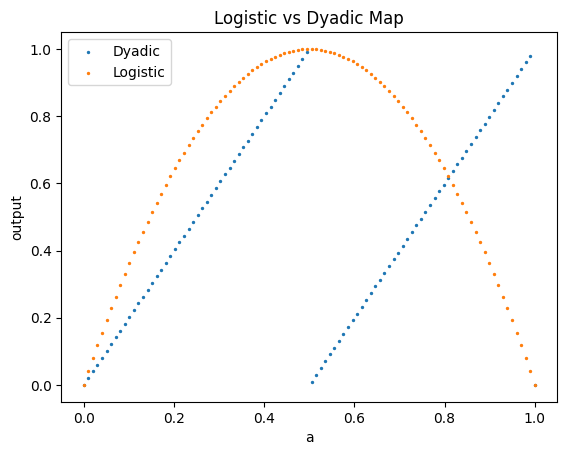

In [ ]:
a_values = np.linspace(0, 1, 100)
def D(a): return (2 * a) % 1
def L(a): return 4 * a * (1 - a)

fig, ax = plt.subplots()
ax.scatter(a_values, D(a_values), label="Dyadic", s=2)
ax.scatter(a_values, L(a_values), label="Logistic", s=2)
ax.set_xlabel("a")
ax.set_ylabel("output")
ax.set_title("Logistic vs Dyadic Map")
ax.legend()
plt.show()

1. go through examples of the oribit of the logisdtic function. use same inputs as before.
2. use different values for the learned parmeter $\alpha$ and the input to the dyadic, logistic map
3. refer to type learned paramater $\alpha$ as the "dataset" parameter. $\alpha$ is the output of the encoder and the input to the decoder.
4. after evey single equation write this eqn does BLANK. or give an example.
5. table to compare/contrast the logistic and dyadic map
6. have a dropdown menu that shows the proof of why we use these transofrmations to get the new values

However, [Topological conjugacy](https://en.wikipedia.org/wiki/Topological_conjugacy) tells us these two maps are *actually* the same. Not similar. Not analgous. The same. They have identical orbits, the exact same chaotic trajectories, simply expressed in different coordinates. The logistic map, for all its smooth curves and elegant form, is actually doing discrete binary operations under the hood, just like the dyadic map (and vice versa). Formally, two functions are topologically conjugate if there exists a homeomorphism, fancy talk for a change of coordinates, that perfectly takes you from one map to another. The change of coordinates here is
$$
\begin{align}
a_L = \phi(a_D) &= \sin^2(2 \pi a_D) 
&
\phi: [0, 1] -> [0, 1]
\\
a_D
=
\phi^{-1}(a_L)
&=
\frac{1}{2 \pi} \arcsin (\sqrt{a_L})
&
\phi^{-1}: [0, 1] -> [0, 1]
\end{align}
$$

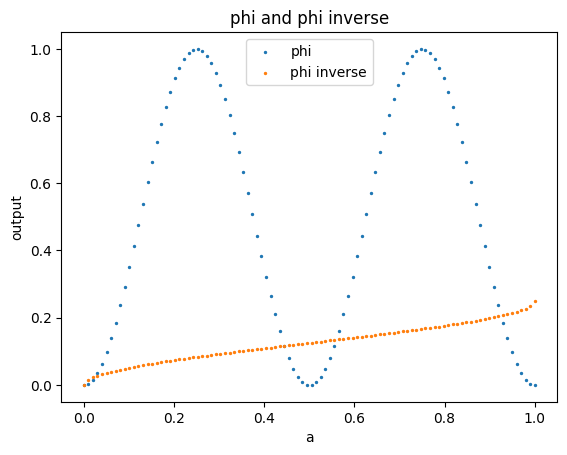

In [ ]:
a_values = np.linspace(0, 1, 100)
def phi(a): return np.sin(2 * np.pi * a) ** 2
def phi_inverse(a): return np.arcsin(np.sqrt(a)) / (2.0 * np.pi)

fig, ax = plt.subplots()
ax.scatter(a_values, phi(a_values), label="phi", s=2)
ax.scatter(a_values, phi_inverse(a_values), label="phi inverse", s=2)
ax.set_xlabel("a")
ax.set_ylabel("output")
ax.set_title("phi and phi inverse")
ax.legend()
plt.show()

The function $\phi$ has a period of 1, meaning it repeats its values every time $a_D$ increases by $1$. This periodicity is crucial because it allows us to drop the modulo operation when transforming from the dyadic space to the logistic space:
$$
\begin{align}
\phi(a_D \mod 1) = \phi(a_D)
\end{align}
$$
To go back and forth between the dyadic and logistic maps, we do
$$
\begin{align}
\mathcal{L}(a_L)
&=
\phi(D(a_D))
\\
\mathcal{D}(a_D)
&=
\mathcal{L}(\phi^{-1}(a_L))
\end{align}
$$
where $\phi$ takes us to the logistic space and operates on the output and $\phi^{-1}$ takes us to the dyadic space and operates on the input. 

What is remarkable about $\phi, \phi^{-1}$ is that it perfectly relates every single point in the infinite orbits of $\mathcal{D}$ and $\mathcal{L}$:
$$
(a_D, \mathcal{D}^1(a_D), \mathcal{D}^2(a_D), ...) = (a_L, \mathcal{L}^1(\phi^{-1})(a_L), \mathcal{L}^2(\phi^{-1})(a_L), ...)
$$
or it can be expressed as
$$
(a_L, \mathcal{L}^1(a_L), \mathcal{L}^2(a_L), ...) = (a_D, \phi(\mathcal{D}^1(a_D)), \phi(\mathcal{D}^2(a_D)), ...)
$$
depending on if we want to be natively using the coordinate system of $\mathcal{D}$ or $\mathcal{L}$. What appears as chaos in one coordinate system manifests as the exact same chaos in the other, no matter how many iterations we apply.

How does this help us? While $\mathcal{D}$ is ugly and discontinuous, $\mathcal{L}$ is smooth and differentiable. We can use the logistic map as "makeup" to hide the crude dyadic operations. So we want our decoder to use $\mathcal{L}$ instead of $\mathcal{D}$. However, this means we need $a$ to also be in the logistic space, not the dyadic space, i.e. we need to compute $a_L$ instead of $a_D$.

**Encoder:** Our bit concatenation trick only works in dyadic space (because of the bit-shifting property). But we want our final parameter in logistic space for smoothness. So we:
1. Transform data to dyadic space: $x_i = \phi^{-1}(x_i)$  for $i=1, ..., n$
2. Do bit concatenation in dyadic space using our decoder $ a_D = g_D(\mathcal{X}) := \text{dec} \Big( \bigoplus_{x \in \mathcal{X}} \text{bin}_p(x) \Big)$
3. Transform data to logistic space $a_L = \phi(a_D)$

Therefore our new encoder is
$$
a_L
=
g_L(\mathcal{X})
:=
\phi(g_D(\phi^{-1}(\mathcal{X})))
=
\phi \bigg( \text{dec} \Big( \bigoplus_{x \in \mathcal{X}} \text{bin}_p(\phi^{-1}(x)) \Big) \bigg)
$$

**Decoder:** Since we have $\alpha$ in logistic space, we can decode directly using logistic iterations
1. Compute logistic map $ \tilde{x}_i = f_{\alpha, p}(i) = \mathcal{L}^{ip}(\alpha)$

Given sample index $i$ and the encoded number $a$, recover sample $\tilde{x_i}$:
1. Apply the dyadic map $D$ exactly $ip$ times $a'_i = \mathcal{D}^{ip}(a) = (2^{ip} a) \mod 1$
2. Extract the first $p$ bits of $a'_i$'s binary representation to get $b_i$, $b_i = \text{bin}_p(a'_i)$
3. Covert to decimal $\tilde{x}_i = \text{dec}(b_i)$

But what is $\mathcal{L}^k(a)$ for any $k$?
$$
\mathcal{L}^k(a)
=
\phi(D^k(a))
=
\phi((2^k a) \mod 1)
=
\phi(2^k a)
$$


**Decoder:**
Instead of decoding with
$$
\tilde{x}_i
=
f_{a, p}(i)
=
\mathcal{D}^{ip}(a)
$$
we will compute this

The $k\text{th}$ iteration of the logistic map is
$$
\begin{align}
\mathcal{L}^k(a)
&=
\phi(\mathcal{D}^k(a))
=
\phi(2^k a \mod 1)
=
\phi(2^k a) = \sin^2(2 \pi \cdot 2^k a)
\end{align}
$$
which we can then plug in to compute the $k$ iteration of the dyadic map
$$
\begin{align}
\mathcal{D}^k(a)
&=
\mathcal{L}^k(\phi^{-1}(a))
=
\mathcal{L}^k \Big( \frac{1}{2 \pi} \arcsin( \sqrt{a}) \Big)
=
\sin^2 \Bigg(2 \pi \cdot 2^k \Big( \frac{1}{2 \pi} \arcsin( \sqrt{a}) \Big) \Bigg)
=
\sin^2 \Bigg(2^k \arcsin( \sqrt{a}) \Bigg)

\end{align}
$$
Therefore our decoder becomes
$$
\tilde{x}_i
=
f_{a, p}(i)
=
\sin^2 \Bigg(2^{ip} \arcsin( \sqrt{a}) \Bigg)
$$



**Encoder:**

When we encode, we will apply $\phi$ to move $a$ from coordinate system of the dyadic map to the coordinate system of the logistic map. And when we decode, we will apply $\phi^{-1}$ to a to bring us back to the dyadic map coordinate system before we apply the decoder. 

# A Long Number

Now here is the clever part: **we can encode all the values in our dataset into a single, long binary string and decode those very samples bit-by-bit using the dyadic map $\mathcal{D}$**.

To make things clearer, we define two functions
1. $b_i = \text{bin}_p(x_i)$ converts a decimal number to a binary number truncated to the first $p$ significant bits
2. $\tilde{x}_i = \text{dec}(b_i)$ converts a binary number to a decimal number

Notice that $\tilde{x}_i \neq x_i$ because we sometimes need more than $p$ bits to accurately represent a number and discard that information in $\text{bin}_p$.

Now, assume we have a dataset $\{x_0, x_1 ..., x_n \}$ where all samples are between $0$ and $1$, $x_i \in [0, 1]$. To encode our dataset, we
1. Convert each sample from decimal to binary with $p$ bits: $b_i = \text{bin}_p(x_i)$ for $i=0, ..., n$
2. Concatenate all the samples into a single, long binary string: $b = b_0 \oplus b_1, ..., \oplus b_n$.

Notice that $b$ has a total of $np$ bits and contains a flattened version of the entire dataset. Now we can discard our original dataset and just keep $b$.

To decode $\tilde{x}_i$ from $b$, we
1. Extract $b_i$ from $b$ by applying the dyadic map $p$ times: $b_i = [\mathcal{D}^j(b), \mathcal{D}^{j+1}(b), ..., \mathcal{D}^{j+p}(b)]
)]$ for $j=ip$.
2. Convert binary to decimal: $\tilde{x}_i = \text{dec}(b_i)$

<div align="center">
    <img src="../../resources/encode_1.png" alt="first encoding step" width="200">
    <p><em>Figure 1: Convert all samples to binary with p bits of precision. [<a href="(https://arxiv.org/pdf/1904.12320">source</a>] </em></p>
</div>

<div align="center">
    <img src="../../resources/encode_2.png" alt="first encoding step" width="600">
    <p><em>Figure 1: Concatenate all samples into a long binary string. [<a href="(https://arxiv.org/pdf/1904.12320">source</a>] </em></p>
</div>

With this encoding scheme, the first $p$ bits correspond to binary $x_0$, the second $p$ bits correspond to $x_1$, and the third $p$ bits correspond to $x_2$. Now the decoding.

For example, if we have the dataset
$$
\mathcal{X}
=
\{0.5, 1/3,  0.43085467085\}
$$
then in binary this dataset is
$$
\mathcal{X}_\text{bin}
=
\{0.1000000000..., 0.0101010101...,  0.0110111001...\}
$$
Notice that each sample currently has an infinite number of binary digits but we cannot concatonate infintely-long sequences together. So we take the the first $p=6$ significant bits of each sample
$$
\mathcal{X}_\text{bin}
\approx
\{0.100000, 0.010101,  0.011011\}
$$
and concatenate it together into a single longer number
$$
a
=
0.100000 010101 011011
$$


In [ ]:
def decimal_to_binary(y_decimal, precision):
    if not isinstance(y_decimal, np.ndarray): y_decimal = np.array(y_decimal)
    if y_decimal.ndim == 0: y_decimal = np.expand_dims(y_decimal, 0)

    powers = 2**np.arange(precision)
    y_powers = y_decimal[:, np.newaxis] * powers[np.newaxis, :]
    y_fractional = y_powers % 1 # extract the fractional part of y_powers
    binary_digits = (y_fractional >= 0.5).astype(int).astype('<U1')
    return np.apply_along_axis(''.join, axis=1, arr=binary_digits).tolist()

decimal_to_binary(0.43085467085, 10)

['0110111001']

In [ ]:
def decimal_to_binary(y_decimal, precision):
    if not isinstance(y_decimal, np.ndarray): y_decimal = np.array(y_decimal)
    if y_decimal.ndim == 0: y_decimal = np.expand_dims(y_decimal, 0)

    powers = 2**np.arange(precision)
    y_powers = y_decimal[:, np.newaxis] * powers[np.newaxis, :]
    y_fractional = y_powers % 1 # extract the fractional part of y_powers
    binary_digits = (y_fractional >= 0.5).astype(int).astype('<U1')
    return np.apply_along_axis(''.join, axis=1, arr=binary_digits).tolist()

decimal_to_binary(1/3, 10)

['0101010101']